In [8]:
batch_size = 32
image_size = 256
vertical_type = "sagittal"
checkpoint = f"checkpoint/sagittal_segmentation_detection_095730-epoch-20.pth"

In [66]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from tqdm import tqdm

from PIL import Image, ImageOps

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

In [4]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

IMAGES_DIR = os.path.join(DATA_DIR, f"train_{vertical_type}_images_jpeg95")
LABEL_DIR = os.path.join(DATA_DIR, f"train_{vertical_type}_labels_jpeg95")

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, 2 * self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(2 * self.out_channels, self.n_features, kernel_size=1, padding='same'),
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=1, padding='same'),
            )
            parallel_modules.append(module)

        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i] // 2, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i] // 2, self.channels[i - 1] if i > 0 else self.out_channels, kernel_size=1),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules

    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i + 1)]
            parallel_output = parallel_outputs[-(i + 1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out

def resnet50_gray():
    model = models.resnet50(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

backbone = resnet50_gray()
channels = [64, 512, 1024, 2048]

model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2).to(device)

In [9]:
state = torch.load(checkpoint)
model.load_state_dict(state["model"])
model = model.eval()

## Transform

In [10]:
class DataTransform(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

    def forward(self, x):
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)
        return x


transform = DataTransform(image_size)

## Dataset

In [108]:
class VerticalImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        super().__init__()
        self.df = df
        self.image_dir = image_dir

        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        df = self.df.iloc[idx]

        UID = df.name
        image_name = int(df[f"{vertical_type}_index"])
        image_path = os.path.join(self.image_dir, UID, f"{image_name}.jpeg")
        image = Image.open(image_path)

        left, top, right, bottom = df[['left','top','right','bottom']]
        image = TF.crop(image, top, left, bottom-top, right-left)

        if self.transform:
            image = self.transform(image)

        return image, UID, image_name

## Inference

In [16]:
xray_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_xray.csv')).set_index('UID')
xray_df = xray_df[xray_df.direction == 2]
xray_df.head()

,direction,z_spacing,pixel_spacing,aspect,width,height
UID,,,,,,
1.2.826.0.1.3680043.10001,2,0.625,0.253906,2.461541,512,659
1.2.826.0.1.3680043.10005,2,0.625,0.298828,2.091504,512,541
1.2.826.0.1.3680043.10014,2,0.800,0.234000,3.418803,512,882
1.2.826.0.1.3680043.10016,2,0.313,0.275391,1.136566,512,733
1.2.826.0.1.3680043.10032,2,0.625,0.320313,1.951216,512,626


In [18]:
len(xray_df)

2012

In [12]:
bbox_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_boundary_throw_anomaly.csv')).set_index('UID')
bbox_df.head()

,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,
1.2.826.0.1.3680043.10001,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10005,66,10,172,142,31,9,166,126
1.2.826.0.1.3680043.10014,79,61,170,239,73,61,182,239
1.2.826.0.1.3680043.10016,83,49,176,192,62,49,166,195
1.2.826.0.1.3680043.10032,74,68,168,223,48,67,179,223


In [61]:
concat_df = pd.concat([xray_df, bbox_df], axis=1)
concat_df.head()

,direction,z_spacing,pixel_spacing,aspect,width,height,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,2,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10005,2,0.625,0.298828,2.091504,512,541,66,10,172,142,31,9,166,126
1.2.826.0.1.3680043.10014,2,0.800,0.234000,3.418803,512,882,79,61,170,239,73,61,182,239
1.2.826.0.1.3680043.10016,2,0.313,0.275391,1.136566,512,733,83,49,176,192,62,49,166,195
1.2.826.0.1.3680043.10032,2,0.625,0.320313,1.951216,512,626,74,68,168,223,48,67,179,223


In [62]:
concat_df.insert(1, 'left', None)
concat_df.insert(1, 'top', None)
concat_df.insert(1, 'right', None)
concat_df.insert(1, 'bottom', None)
concat_df.head()

,direction,bottom,right,top,left,z_spacing,pixel_spacing,aspect,width,height,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,2,None,None,None,None,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10005,2,None,None,None,None,0.625,0.298828,2.091504,512,541,66,10,172,142,31,9,166,126
1.2.826.0.1.3680043.10014,2,None,None,None,None,0.800,0.234000,3.418803,512,882,79,61,170,239,73,61,182,239
1.2.826.0.1.3680043.10016,2,None,None,None,None,0.313,0.275391,1.136566,512,733,83,49,176,192,62,49,166,195
1.2.826.0.1.3680043.10032,2,None,None,None,None,0.625,0.320313,1.951216,512,626,74,68,168,223,48,67,179,223


In [63]:
def get_original_position(size, bbox, tol=0.1):
    """
    original position out of 512
    :param size: [h, w] usually 512
    :param bbox: numpy 4, bbox position [left, top, right, bottom] max number 256
    :return:
    """
    h, w = size
    left, top, right, bottom = bbox * max(size) / 256
    pad = (max(size) - min(size)) // 2  # pad number of left or top
    if w > h:
        left, top, right, bottom = [left, -pad + top, right, -pad + bottom]
    else:
        left, top, right, bottom = [-pad + left, top, -pad + right, bottom]
    w_tol = (right - left) * tol
    h_tol = (bottom - top) * tol
    left, top, right, bottom = left - w_tol, top - h_tol, right + w_tol, bottom + h_tol
    return int(math.floor(max(0, left))), int(math.floor(max(0, top))), int(math.ceil(min(w, right))), int(math.ceil(min(h, bottom)))

In [67]:

for i in tqdm(range(len(concat_df))):
    row =  concat_df.iloc[i]
    UID = row.name
    series =  concat_df.loc[UID]
    # print(series[["height", "width"]])
    left, top, right, bottom = get_original_position(series[["height", "width"]].values, concat_df.loc[UID, [f"{vertical_type}_left", f"{vertical_type}_top",f"{vertical_type}_right",f"{vertical_type}_bottom"]], tol=0.1)
    # print(np.asarray([[left, top, right, bottom]]).repeat(len( concat_df.loc[UID]), axis=0).transpose().shape)
    #  concat_df.loc[UID, ['left','top','right','bottom']] = np.asarray([[left, top, right, bottom]]).repeat(len( concat_df.loc[UID]), axis=0)
    concat_df.loc[UID, ['left', 'top', 'right', 'bottom']] = left, top, right, bottom
concat_df.head()

100%|██████████| 2012/2012 [00:04<00:00, 475.70it/s]


,direction,bottom,right,top,left,z_spacing,pixel_spacing,aspect,width,height,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,2,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10005,2,291,366,0,22,0.625,0.298828,2.091504,512,541,66,10,172,142,31,9,166,126
1.2.826.0.1.3680043.10014,2,882,480,148,28,0.800,0.234000,3.418803,512,882,79,61,170,239,73,61,182,239
1.2.826.0.1.3680043.10016,2,601,396,98,37,0.313,0.275391,1.136566,512,733,83,49,176,192,62,49,166,195
1.2.826.0.1.3680043.10032,2,584,413,125,28,0.625,0.320313,1.951216,512,626,74,68,168,223,48,67,179,223


In [68]:
concat_df.insert(1, f'{vertical_type}_index', None)

In [71]:
df = pd.DataFrame()

In [72]:
for i in tqdm(range(len(concat_df))):
    s = concat_df.iloc[i]
    UID = s.name
    if vertical_type == 'sagittal':
        left, top, right, bottom = get_original_position(s[["height", "width"]].values, concat_df.loc[UID, [f"coronal_left", f"coronal_top",f"coronal_right",f"coronal_bottom"]], tol=0.1)

        new_df = concat_df.loc[[UID] * (right - left + 1)]
        new_df[f"{vertical_type}_index"] = np.arange(left, right + 1)
        df = pd.concat([df, new_df])
    else:
        left, top, right, bottom = get_original_position(s[["height", "width"]].values, concat_df.loc[UID, [f"sagittal_left", f"sagittal_top",f"sagittal_right",f"sagittal_bottom"]], tol=0.1)

        new_df = concat_df.loc[[UID] * (right - left + 1)]
        new_df[f"{vertical_type}_index"] = np.arange(left, right + 1)
        df = pd.concat([df, new_df])

df.head()

100%|██████████| 2012/2012 [00:54<00:00, 36.89it/s]


,direction,sagittal_index,bottom,right,top,left,z_spacing,pixel_spacing,aspect,width,height,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,2,88,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,89,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,90,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,91,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,92,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213


In [78]:
df.loc["1.2.826.0.1.3680043.10001"]

,direction,sagittal_index,bottom,right,top,left,z_spacing,pixel_spacing,aspect,width,height,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,2,88,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,89,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,90,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,91,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,92,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.10001,2,428,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,429,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,430,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213


In [74]:
len(df)

556697

In [113]:
# df.to_csv('infer_sagittal_position.csv')

### Inference images

In [109]:
dataset = VerticalImageDataset(df, IMAGES_DIR, transform)
len(dataset)

556697

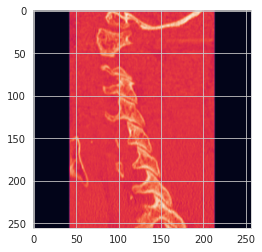

In [110]:
x, _, _ = dataset[100]
img = x * 0.5 + 0.5
plt.imshow(img.squeeze().cpu().numpy())

In [88]:
def predict(model, x):
    x = x.to(device)
    classification_prob, mse_score = model(x).sigmoid().chunk(2, dim=1)
    mse_score = torch.round(mse_score * 8.) / 8.
    pred = classification_prob.gt(0.5).float() * mse_score
    return pred

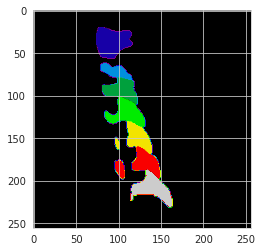

In [111]:
with torch.no_grad():
    x = x.unsqueeze(0)
    pred = predict(model, x)
    pred = pred.squeeze().cpu().numpy()
    pred = pred * 32
    Image.fromarray(np.uint8(pred), 'L').save('sample_infer.png')
    plt.imshow(pred, cmap='nipy_spectral')

In [114]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=16)

In [115]:
def save_pred_image(pred, UIDs, image_names):
    pred = pred * 32
    for i in range(pred.shape[0]):
        label_dir = os.path.join(LABEL_DIR, UIDs[i])
        if os.path.exists(label_dir) == False:
            os.mkdir(label_dir)
        label = pred[i, 0, :, :]
        img_path = os.path.join(label_dir, f"{image_names[i]}.png")
        img_full_path = os.path.join(LABEL_DIR, img_path)
        Image.fromarray(np.uint8(label), 'L').save(img_full_path)

In [116]:
with torch.no_grad():
    train_iter = tqdm(dataloader)
    for x, UIDs, image_names in train_iter:
        pred = predict(model, x)
        save_pred_image(pred.cpu().numpy(), UIDs, image_names)

  0%|          | 14/17397 [00:08<2:54:30,  1.66it/s]


KeyboardInterrupt: 